In [2]:
import torch
import numpy as np
import math
import os
import matplotlib.pyplot as plt

In [16]:
num_notes = 128
num_time_shifts = 100
num_velocities = 32
message_dim = 2*num_notes + num_velocities + num_time_shifts
instrument_numbers = [0, 6, 40, 41, 42, 43, 45, 60, 68, 70, 71, 73]
num_instruments = len(instrument_numbers)
max_channels = 14

# ComposerLSTM definition

Predicts the next message given the message history and available instruments

In [4]:
# ComposerLSTM: takes a history of MIDI messages 
# and generates a distribution for the next message
class ComposerLSTM(torch.nn.Module):
    # CONSTRUCTOR
    # ARGUMENTS
    # message_dim: dimension of a MIDI message
    # embed_dim: dimension of message embedding
    # num_instruments: number of instrument labels
    # hidden_size: size of hidden LSTM state
    # heads: number of heads used to compute ensemble vector
    # recurrent_layers: the number of layers in the lstm
    def __init__(self, message_dim, embed_dim, num_instruments, hidden_size, heads, recurrent_layers=3):
        super(ComposerLSTM, self).__init__()
        
        self.embed_dim = embed_dim
        
        # We use multiheaded attention to transform the ensemble into a single vector
        self.i_embedding = torch.nn.Embedding(num_instruments, embed_dim)
        self.inst_attention = torch.nn.MultiheadAttention(embed_dim, heads)
        
        self.embedding = torch.nn.Embedding(message_dim, embed_dim)
        
        # A 3-layer LSTM takes the history of messages (concatenated with the ensemble
        # vector) and produces a decoding
        self.lstm = torch.nn.LSTM(2*embed_dim, hidden_size, num_layers=recurrent_layers)

        # The decoding is passed through a linear layer to get the logits for the next message        
        self.logits = torch.nn.Linear(hidden_size, message_dim)
    
    # forward: generates a probability distribution for the next MIDI message
    # ARGUMENTS
    # history: an LxB tensor, where L is the length of the longest message history in
    # the batch, and B is the batch size. This should be END-PADDED
    # along dimension 0
    # mask: an LxB tensor, containing True in any locations where history contains padding
    # instruments: a NxB tensor indicating the instruments in each channel. This should be END-PADDED along dimension 0
    # inst_mask: an NxB tensor containing False where an instrument exists and True otherwise
    # RETURN: an LxBxD tensor representing the logits for the next message in each batch
    def forward(self, history, mask, instruments, inst_mask):
        L = history.shape[0] # longest length
        B = history.shape[1] # batch size
        assert(mask.shape == history.shape)
        assert(instruments.shape == inst_mask.shape)
        
        # NxBxD
        inst_embed = torch.tanh(self.i_embedding(instruments))
               
        # 1xBxD
        ensemble_vec, weights = self.inst_attention(torch.ones((1, B, self.embed_dim)), \
                                                    inst_embed, \
                                                    inst_embed, \
                                                    inst_mask.transpose(0, 1))
        
        # LxBxD
        inputs = torch.cat((self.embedding(history), ensemble_vec.expand(L, -1, -1)), dim=2)
        
        decoding, last_hidden = self.lstm(inputs)
        
        # LxBxD
        return self.logits(decoding)
    
    # forward: predicts the next MIDI message
    # ARGUMENTS
    # last_message: a 1x1 tensor containing the last message
    # instruments: an Nx1 tensor indicating the instrument number for each channel
    # hidden: the last hidden state for the LSTM
    # RETURN: a 1x1 tensor, predicting the next message
    def forward_generate(self, last_message, instruments, hidden):
        assert(last_message.shape == (1, 1))
        
        # Nx1xD
        inst_embed = torch.tanh(self.i_embedding(instruments))
               
        # 1x1xD
        ensemble_vec, weights = self.inst_attention(torch.ones((1, 1, self.embed_dim)), inst_embed, inst_embed)
        
        # 1x1xD
        inputs = torch.cat((self.embedding(last_message), ensemble_vec), dim=2)
        
        decoding, new_hidden = self.lstm(inputs, hidden)
        
        # 1x1xD
        probs = torch.nn.functional.softmax(self.logits(decoding), dim=2)
               
        return torch.multinomial(probs.flatten(), 1).view(1, 1), new_hidden

# Tests for ComposerLSTM
We train with model.eval() to disable dropout, since these tests try to get the model to overfit to a small sequence

Get the model to overfit to a single song

In [47]:
embed_dim = 256
hidden_size = 1024
heads = 4

grad_clip = 10

model = ComposerLSTM(message_dim, embed_dim, num_instruments, hidden_size, heads)
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))
    
model.eval() # Training with eval just to see if we can overfit without dropout
pass

In [48]:
model.load_state_dict(torch.load('overfit_composer.pth'))

<All keys matched successfully>

In [ ]:
recording = np.load('train_unified/recording0.npy', allow_pickle=True)
instruments_np = np.load('train_unified/instruments0.npy', allow_pickle=True)

nsamples = 200

message_history = torch.tensor(recording[:nsamples, 0], dtype=torch.long).view(-1, 1)
mask = torch.zeros(message_history.shape, dtype=torch.bool)
instruments = torch.tensor([instrument_numbers.index(i) for i in instruments_np], dtype=torch.long).view(-1, 1)
inst_mask = torch.zeros(instruments.shape, dtype=torch.bool)

batch_size = 1
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 500
train_losses = np.zeros(epochs)

target_messages = message_history[1:].flatten()

for epoch in range(epochs):
    print('Starting epoch %d' %(epoch))
    
    message_logits = model(message_history[:-1], mask[:-1], instruments, inst_mask)
    
    loss = loss_fn(message_logits.view(-1, message_dim), target_messages)
                
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses[epoch] = loss.data
    print('Loss: %f' %(loss.data))

In [23]:
torch.save(model.state_dict(), 'overfit_composer.pth')

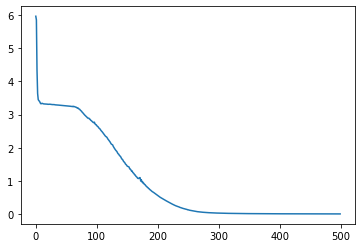

In [24]:
plt.plot(train_losses)

In [54]:
# Sample from model
gen_messages = message_history[0].unsqueeze(0)
model.eval() # Turns off the dropout for evaluation. Need to do this to get repeatable evaluation outputs

# Move forward in time
wrong_cnt = 0
hidden = (torch.zeros(3, 1, hidden_size), torch.zeros(3, 1, hidden_size))
for t in range(0, message_history.shape[0] - 1):
    ret, hidden = model.forward_generate(gen_messages[-1].view(1, 1), instruments, hidden)
    
    gen_messages = torch.cat((gen_messages, ret), dim=0)
    
    if gen_messages[-1, 0] != message_history[t + 1, 0]:
        print('Wrong message at time %d!' %(t))
        wrong_cnt += 1

print(wrong_cnt)

0


In [55]:
# Associate all messages with channel 0 for now
channels = torch.zeros(gen_messages.shape, dtype=torch.long)
gen_history = torch.cat((gen_messages, channels), dim=1)
np.save('test_history.npy', gen_history.detach().numpy())
np.save('test_instruments.npy', np.array([0]))

# Custom dataset class

In [20]:
# Custom Dataset class
class MIDIDataset(torch.utils.data.Dataset):
    # CONSTRUCTOR: creates a tensor of message chunks and associated instruments.
    # Assumes that the directory contains recording0.npy to recordingM.npy
    # as well as instruments0.npy to instrumentsM.npy
    # ARGUMENTS
    # root_dir: the directory to search
    # chunk_size: we'll chunk the data into chunks of this size (or less)
    # max_channels: what's the largest number of instruments in any file?
    def __init__(self, root_dir, chunk_size, max_channels, transform=None):
        files = os.listdir(root_dir)
        recording_files = []
        instrument_files = []
        for file in files:
            if 'recording' in file:
                recording_files.append(os.path.join(root_dir, file))
            elif 'instruments' in file:
                instrument_files.append(os.path.join(root_dir, file))
                
        assert(len(recording_files) == len(instrument_files))
        recording_files.sort()
        instrument_files.sort()
        
        self.chunks = []
        self.masks = []
        self.instruments = []
        self.inst_masks = []
        
        ch = 0
        for f in range(len(recording_files)):
            recording = np.load(recording_files[f], allow_pickle=True)
            inst = [instrument_numbers.index(i) for i in np.load(instrument_files[f], allow_pickle=True)]
            
            nchunks = int(np.ceil(recording.shape[0]/chunk_size))
            self.chunks += [torch.zeros(chunk_size, dtype=torch.long) for c in range(nchunks)]
            self.masks += [torch.ones(chunk_size, dtype=torch.bool) for c in range(nchunks)]
            self.instruments += [torch.zeros(max_channels, dtype=torch.long) for c in range(nchunks)]
            self.inst_masks += [torch.ones(max_channels, dtype=torch.long) for c in range(nchunks)]
            for chunk_start in range(0, recording.shape[0], chunk_size):
                chunk_end = min(chunk_start + chunk_size, recording.shape[0])
                size = chunk_end - chunk_start
                self.chunks[ch][:size] = torch.tensor(recording[chunk_start:chunk_end, 0], dtype=torch.long)
                self.masks[ch][:size] = False
                self.instruments[ch][:len(inst)] = torch.tensor(inst, dtype=torch.long)
                self.inst_masks[ch][:len(inst)] = False
                ch += 1
            
        self.transform = transform

    # __len__
    # RETURN: the number of recording chunks in the dataset
    def __len__(self):
        return len(self.chunks)

    # __getitem__
    # ARGUMENTS
    # idx: indicates which chunk(s) to get
    # RETURN: instance, a dictionary with keys 'history', 'instruments', 'mask', and 'inst_mask'
    # instance['history'] is a length L tensor containing messages
    # instance['instruments'] a length N tensor of instrument numbers
    # instance['mask'] a length L tensor containing False where messages exist and True otherwise
    # instance['inst_mask'] a length N tensor containing False where instruments exist and True otherwise
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        instance = {'history': self.chunks[idx], \
                    'instruments': self.instruments[idx],
                    'mask': self.masks[idx],
                    'inst_mask': self.inst_masks[idx]}
        
        if self.transform:
            instance = self.transform(instance)
            
        return instance
    
def collate_fn(batch):
    chunk_size = batch[0]['history'].shape[0]
    max_channels = batch[0]['instruments'].shape[0]
    sample = {'history': torch.zeros((chunk_size, len(batch)), dtype=torch.long), \
              'instruments': torch.ones((max_channels, len(batch)), dtype=torch.long), \
              'mask': torch.ones((chunk_size, len(batch)), dtype=torch.bool),
              'inst_mask': torch.ones((max_channels, len(batch)), dtype=torch.bool)}
    
    for b, instance in enumerate(batch):
        sample['history'][:, b] = instance['history']
        sample['instruments'][:, b] = instance['instruments']
        sample['mask'][:, b] = instance['mask']
        sample['inst_mask'][:, b] = instance['inst_mask']
    return sample

# Train the model

In [21]:
# compute_loss: computes the loss for the model over the batch
# ARGUMENTS
# model: ComposerLSTM model
# loss_fn: torch.nn.CrossEntropyLoss object
# batch: see collate_fn definition
# RETURN: a scalar loss tensor
def compute_loss(model, loss_fn, batch):
    batch_size = batch['history'].shape[1]
    
    max_seq_length = batch['history'].shape[0]
        
    num_targets = max_seq_length - 1 # Messages start from t = 0, but we start generating at t = 1

    message_logits = model(batch['history'][:-1], batch['mask'][:-1], batch['instruments'], batch['inst_mask'])

    target_mask = torch.logical_not(batch['mask'][1:])

    target_messages = batch['history'][1:][target_mask]

    message_loss = loss_fn(message_logits[target_mask], target_messages)

    return message_loss

In [22]:
embed_dim = 256
hidden_size = 1024
heads = 4

grad_clip = 10

model = ComposerLSTM(message_dim, embed_dim, num_instruments, hidden_size, heads)
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))

In [23]:
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
batch_size = 10
learning_rate = 0.001
chunk_size = 500

train_dataset = MIDIDataset('train_unified', chunk_size, max_channels)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

test_dataset = MIDIDataset('test_unified', chunk_size, max_channels)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

loss_fn = torch.nn.CrossEntropyLoss()
epochs = 20
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)

for epoch in range(epochs):
    print('Starting epoch %d' %(epoch))
    model.train()
    for b, batch in enumerate(train_dataloader):
        print('Starting iteration %d' %(b))
        loss = compute_loss(model, loss_fn, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    torch.save(model.state_dict(), 'composer_models/epoch' + str(epoch) + '.pth')

    print('Computing test loss')
    model.eval()
    for batch in test_dataloader:
        loss = compute_loss(model, loss_fn, batch)
        test_losses[epoch] += loss.data
        
    print('Computing train loss')
    for batch in train_dataloader:
        loss = compute_loss(model, loss_fn, batch)
        train_losses[epoch] += loss.data
    
    train_losses[epoch] /= len(train_dataloader)
    test_losses[epoch] /= len(test_dataloader)
    print('Train Loss: %f, Test Loss: %f' %(train_losses[epoch], test_losses[epoch]))

In [ ]:
plt.plot(train_losses)

# Sample from the model

In [115]:
model.eval() # Disable dropout to make results repeatable

time_steps = 500 # How many time steps do we sample?

# Start with a time shift
gen_messages = torch.tensor(387).view(1, 1)
model.eval() # Turns off the dropout for evaluation. Need to do this to get repeatable evaluation outputs

# Piano
instruments = torch.zeros((1, 1), dtype=torch.long)
instruments[0, 0] = 0

# Move forward in time
wrong_cnt = 0
hidden = (torch.zeros(3, 1, hidden_size), torch.zeros(3, 1, hidden_size))
for t in range(time_steps):
    ret, hidden = model.forward_generate(gen_messages[-1].view(1, 1), instruments, hidden)
    
    gen_messages = torch.cat((gen_messages, ret), dim=0)

In [116]:
# Associate all messages with channel 0 for now
channels = torch.zeros(gen_messages.shape, dtype=torch.long)
gen_history = torch.cat((gen_messages, channels), dim=1)
np.save('test_history.npy', gen_history.detach().numpy())
np.save('test_instruments.npy', np.array([0]))